In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [7]:
llm_responses_file = "generated_responses_ee_60k_r32.json"
ee_val_info_file = "../../../../../datasets/reproduced method/ee/ee_val_data.json"

In [8]:
criteria = "EE"

In [9]:
# Load LLM responses from the generated responses file
with open(llm_responses_file, "r") as f:
    llm_responses = json.load(f)

In [10]:
# Load additional information for the validation dataset
with open(ee_val_info_file, "r") as f:
    ee_val_info = json.load(f)

In [11]:
# Create a dictionary for quick access based on sample_index
ee_val_info_dict = {record["sample_index"]: record for record in ee_val_info}

In [12]:
# Calculate data rate for single channel, single sample
def cal_RATE_one_sample_one_channel(channel, tx_power, noise):
    diag_ch = np.diag(channel)
    inter_ch = channel - np.diag(diag_ch)
    tot_ch = np.multiply(channel, np.expand_dims(tx_power, -1))
    int_ch = np.multiply(inter_ch, np.expand_dims(tx_power, -1))
    sig_ch = np.sum(tot_ch - int_ch, axis=1)
    int_ch = np.sum(int_ch, axis=1)
    SINR_val = np.divide(sig_ch, int_ch + noise)
    cap_val = np.log2(1.0 + SINR_val)
    return cap_val

# Calculate spectral and energy efficiencies
def cal_SE_EE(channel, tx_max, noise, DUE_thr, I_thr, P_c, tx_power_mat, opt="SE"):
    num_channel = 1
    num_D2D_user = channel.shape[0] - 1
    tot_SE = 0

    cur_cap = 0
    DUE_mask = 1
    CUE_mask = 1

    tx_power = np.vstack((tx_power_mat, 0 * np.ones((1, 1))))
    tx_power = np.expand_dims(tx_power, 0)

    cur_ch = channel
    cur_ch_cap = cal_RATE_one_sample_one_channel(cur_ch, tx_power[:, :, 0], noise)
    cur_cap = cur_cap + cur_ch_cap

    sum_D2D_SE_temp = np.sum(cur_cap[0, :-1])
    sum_D2D_EE_temp = np.sum(cur_cap[0, :-1] / (tx_power[0, :-1, 0] + P_c))

    D2D_SE_sum = sum_D2D_SE_temp
    D2D_EE_sum = sum_D2D_EE_temp

    return D2D_SE_sum, D2D_EE_sum

In [13]:
# Initialize lists to store results
original_EE_list = []
predicted_EE_list = []
random_EE_list = []

# Process each LLM response and calculate SE and EE
for response in llm_responses:
    sample_index = int(response["sample_index"])

    # Get the original information from the corresponding dataset
    if sample_index in ee_val_info_dict:
        original_info = ee_val_info_dict[sample_index]
    else:
        print(f"Sample index {sample_index} not found in any dataset.")
        continue

    # Extract necessary fields
    channel = np.array(original_info["chan_mat_values"])
    tx_max = original_info["tx_max"]
    noise = original_info["noise"]
    DUE_thr = original_info["DUE_thr"]
    I_thr = original_info["I_thr"]
    P_c = original_info["P_c"]
    original_power = np.array(original_info["pw_vec_values"]).flatten().reshape(2, 1)
    try:
        predicted_power = np.fromstring(response["predicted_response"], sep=',').flatten().reshape(2, 1)
    except:
        continue

    # Generate random power values between 0 and tx_max for comparison
    random_power = np.random.uniform(0, tx_max, original_power.shape)

    # Compute original SE and EE
    original_SE, original_EE = cal_SE_EE(channel, tx_max, noise, DUE_thr, I_thr, P_c, original_power, opt=criteria)
    original_EE_list.append(original_EE)

    # Compute predicted SE and EE if the shapes match
    if predicted_power.shape == original_power.shape:
        predicted_SE, predicted_EE = cal_SE_EE(channel, tx_max, noise, DUE_thr, I_thr, P_c, predicted_power, opt=criteria)
        predicted_EE_list.append(predicted_EE)
    else:
        print(f"Predicted power shape mismatch for sample index {sample_index}. Skipping predicted values.")

    # Compute random SE and EE
    random_SE, random_EE = cal_SE_EE(channel, tx_max, noise, DUE_thr, I_thr, P_c, random_power, opt=criteria)
    random_EE_list.append(random_EE)

# Calculate mean metrics for original, predicted, and random values
mean_original_EE = np.mean(original_EE_list)
mean_predicted_EE = np.mean(predicted_EE_list)
mean_random_EE = np.mean(random_EE_list)

# Print the results
print(f"Mean Original Energy Efficiency (EE): {mean_original_EE*1000}")
print(f"Mean Predicted Energy Efficiency (EE): {mean_predicted_EE*1000}")
print(f"Mean Random Energy Efficiency (EE): {mean_random_EE*1000}")

Mean Original Energy Efficiency (EE): 31.358535660560737
Mean Predicted Energy Efficiency (EE): 23.617820442337187
Mean Random Energy Efficiency (EE): 21.313293773643654


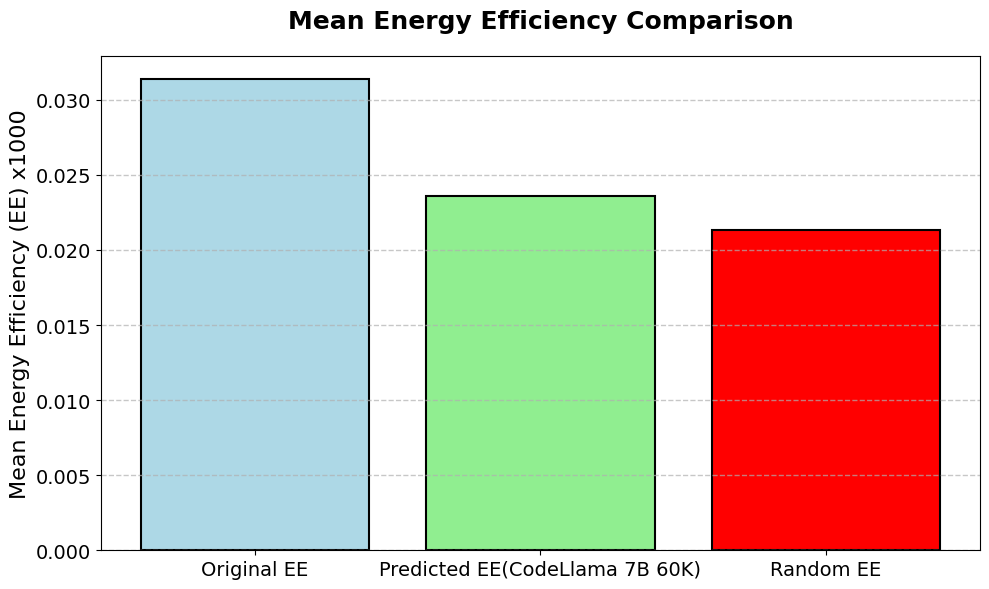

In [14]:
# Create a list of means and corresponding labels
mean_values = [mean_original_EE, mean_predicted_EE, mean_random_EE]
labels = ["Original EE", "Predicted EE(CodeLlama 7B 60K)", "Random EE"]
scaling_factor = 1000

# Create a new figure for the bar chart
plt.figure(figsize=(10, 6))

# Plot the bar chart
bars = plt.bar(labels, mean_values, color=['lightblue', 'lightgreen', 'red'], edgecolor='black', linewidth=1.5)

# Set the labels and title
plt.ylabel(f"Mean Energy Efficiency (EE) x{scaling_factor}", fontsize=16)
plt.title("Mean Energy Efficiency Comparison", fontsize=18, weight='bold', pad=20)

# Customize the grid and axis styles
plt.grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

/home/work/py_venv/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/home/work/py_venv/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)
/home/work/py_venv/lib/python3.12/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


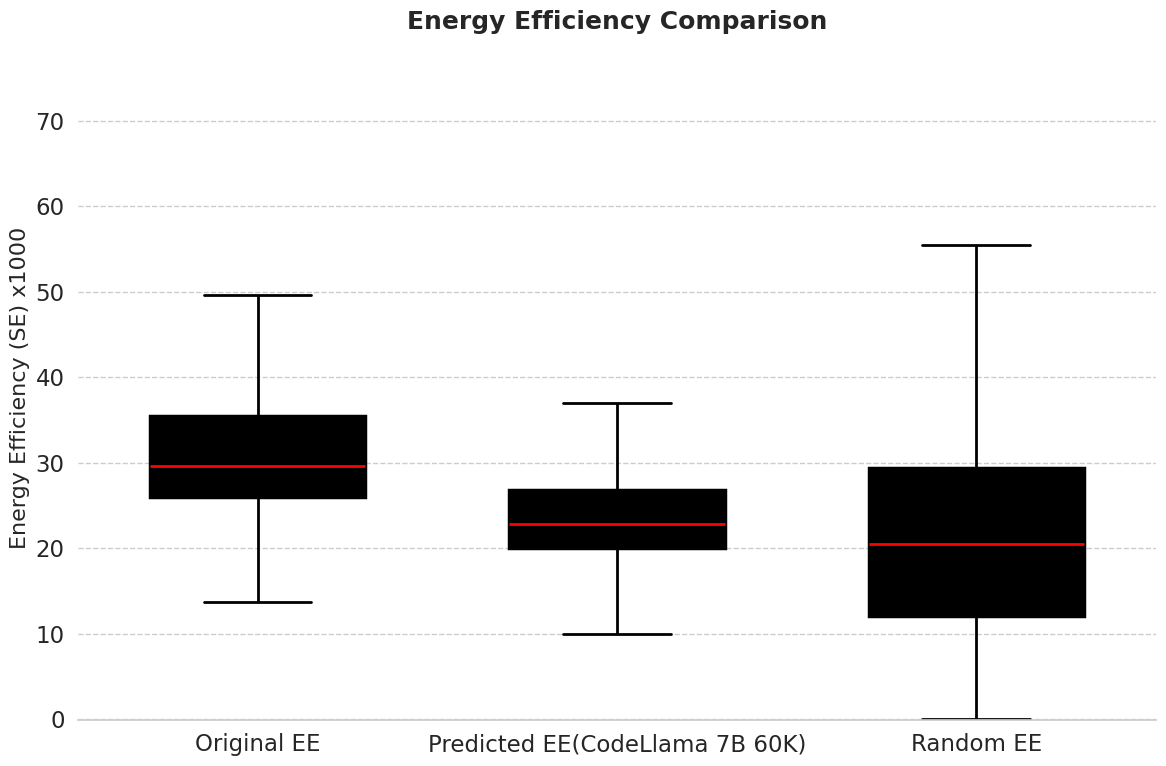

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plot
sns.set(style="whitegrid", palette="pastel", font_scale=1.5)

# Scaling factor to make SE values more readable
scaling_factor = 1000  # Multiply SE values by this factor

# Scale the SE values for better visualization
scaled_original_EE_list = [x * scaling_factor for x in original_EE_list]
scaled_predicted_EE_list = [x * scaling_factor for x in predicted_EE_list]
scaled_random_EE_list = [x * scaling_factor for x in random_EE_list]

# Create a new figure
plt.figure(figsize=(12, 8))

# Create the box plot with additional styling
sns.boxplot(data=[scaled_original_EE_list, scaled_predicted_EE_list, scaled_random_EE_list], 
            width=0.6, 
            linewidth=2.5, 
            boxprops=dict(facecolor="skyblue", color="black"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="black", linewidth=2),
            capprops=dict(color="black", linewidth=2),
            flierprops=dict(markerfacecolor='grey', marker='o', markersize=8),
            showfliers=False)

# Set the labels and title
plt.xticks([0, 1, 2], ["Original EE", "Predicted EE(CodeLlama 7B 60K)", "Random EE"])
plt.title("Energy Efficiency Comparison", fontsize=18, weight='bold', pad=20)
plt.ylabel(f"Energy Efficiency (SE) x{scaling_factor}", fontsize=16)

# Set y-axis limits based on data range, adding some padding for visibility
min_value = min(scaled_original_EE_list + scaled_predicted_EE_list + scaled_random_EE_list)
max_value = max(scaled_original_EE_list + scaled_predicted_EE_list + scaled_random_EE_list)
padding = (max_value - min_value) * 0.001  # 5% padding
plt.ylim(min_value - padding, max_value + padding)

# Add gridlines and remove top/right borders
sns.despine(left=True)
plt.grid(axis='y', linestyle='--', linewidth=1)

# Show the plot
plt.tight_layout()
plt.show()
